In [1]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, wright_lower_bound,\
    intersection_mart, plot_marts_eta, construct_eta_grid, union_intersection_mart, selector
np.random.seed(123456789)

In [10]:
N = [50, 100]
x = [np.ones(50) * 0.5, np.ones(100) * 0.5]
lam_func = Bets.fixed
allocation_func = Allocations.proportional_round_robin
alpha = 0.05
breaks = 1000

In [11]:
w = N/np.sum(N) #stratum weights
K = len(N)
lcbs = []
for k in np.arange(K):
    lcbs.append(lower_confidence_bound(
        x = x[k],
        lam_func = lam_func,
        alpha = 1 - (1 - alpha)**(1/K),
        breaks = breaks))
T_k = selector(x, N, allocation_func, eta = None, lam_func = lam_func)
running_lcbs = np.zeros((T_k.shape[0], K))
for i in np.arange(T_k.shape[0]):
    running_lcbs[i,:] = np.array([lcbs[k][T_k[i, k]] for k in np.arange(K)])
global_lcb = np.matmul(running_lcbs, w)

IndexError: index 50 is out of bounds for axis 0 with size 50

In [19]:
T_k[i,0]

50

In [4]:
selector(x, N, allocation_func = Allocations.proportional_round_robin, eta = None, lam_func = None)

array([[  0,   0],
       [  1,   0],
       [  1,   1],
       [  1,   2],
       [  2,   2],
       [  2,   3],
       [  2,   4],
       [  3,   4],
       [  3,   5],
       [  3,   6],
       [  4,   6],
       [  4,   7],
       [  4,   8],
       [  5,   8],
       [  5,   9],
       [  5,  10],
       [  6,  10],
       [  6,  11],
       [  6,  12],
       [  7,  12],
       [  7,  13],
       [  7,  14],
       [  8,  14],
       [  8,  15],
       [  8,  16],
       [  9,  16],
       [  9,  17],
       [  9,  18],
       [ 10,  18],
       [ 10,  19],
       [ 10,  20],
       [ 11,  20],
       [ 11,  21],
       [ 11,  22],
       [ 12,  22],
       [ 12,  23],
       [ 12,  24],
       [ 13,  24],
       [ 13,  25],
       [ 13,  26],
       [ 14,  26],
       [ 14,  27],
       [ 14,  28],
       [ 15,  28],
       [ 15,  29],
       [ 15,  30],
       [ 16,  30],
       [ 16,  31],
       [ 16,  32],
       [ 17,  32],
       [ 17,  33],
       [ 17,  34],
       [ 18,

## Wright's method vs UI-NNSM for non-random populations

In the cell below, we construct a range of $K=2$ strata populations. Each stratum is just a point-mass, so the samples are not in fact random. We alter the global alternative (`alt_grid`), the spread between the stratum values (`delta_grid`), the sample size from each stratum (`n_grid`), and the type of bet ($\lambda_i$) used (`bets_dict`). We see whether a test based on wright's method, a UI-NNSM using product combining, or a UI-NNSM using Fisher combining rejects the global null of $\eta_0 = 0.5$ at level $\alpha = 0.05$. The tests reject after all $n_0 + n_1$ samples are consumed (we do not take running maxes over $t$ or deal with stratum allocation $T_k(t)$). There is no need to replicate the experiments because there is no randomness involved anywhere.  

In [4]:
alt_grid = [0.55, 0.6, 0.7]
delta_grid = [0, 0.1, 0.5]
n_grid = [5,15,30]
alpha = 0.05
eta_0 = 0.5
bets_grid = ["fixed", "agrapa", "smooth_predictable"]
bets_dict = {"fixed":Bets.lam_fixed, "agrapa":Bets.lam_agrapa, "smooth_predictable":Bets.lam_smooth_predictable}
K = 2
N = [30, 30]
results = []
#TODO: add UI-NNSMs with different combining functions 
for alt, delta, n_0, n_1, bet in itertools.product(alt_grid, delta_grid, n_grid, n_grid, bets_grid):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [[0, means[0]],[0, means[1]]]
    samples = [np.ones(n_0) * means[0], np.ones(n_1) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N) 
    wlb_reject = wright_lower_bound(
        x = samples, 
        N = N, 
        lam_func = bets_dict[bet], 
        alpha = alpha, 
        breaks = 1000) > eta_0
    uinnsm_product_reject = union_intersection_mart(
        x = samples, 
        etas = eta_grid, 
        lam_func = bets_dict[bet], 
        combine = "product", 
        log = False)[0] > 1/alpha
    uinnsm_fisher_reject = union_intersection_mart(
        x = samples, 
        etas = eta_grid, 
        lam_func = bets_dict[bet], 
        combine = "fisher", 
        log = False)[0] < alpha
    data_dict = {
        "alt":alt, 
        "delta":delta, 
        "n_0":n_0, 
        "n_1":n_1, 
        "bet":str(bet), 
        "wright" : wlb_reject, 
        "uinnsm_product" : uinnsm_product_reject,
        "uinnsm_fisher" : uinnsm_fisher_reject}
    results.append(data_dict)
results = pd.DataFrame(results)

In [5]:
#all results
print(results.to_string())

      alt  delta  n_0  n_1                 bet  wright  uinnsm_product  uinnsm_fisher
0    0.55    0.0    5    5               fixed   False           False          False
1    0.55    0.0    5    5              agrapa   False           False          False
2    0.55    0.0    5    5  smooth_predictable   False           False          False
3    0.55    0.0    5   15               fixed   False           False          False
4    0.55    0.0    5   15              agrapa   False           False          False
5    0.55    0.0    5   15  smooth_predictable   False           False          False
6    0.55    0.0    5   30               fixed   False           False          False
7    0.55    0.0    5   30              agrapa   False           False          False
8    0.55    0.0    5   30  smooth_predictable   False           False          False
9    0.55    0.0   15    5               fixed   False           False          False
10   0.55    0.0   15    5              agrapa   False

In [6]:
#crosstab: the fishser uinnsm dominates wright's method in this setting
pd.crosstab(results['wright'], results['uinnsm_fisher'])

uinnsm_fisher,False,True
wright,,
False,210,12
True,0,21


In [7]:
#and is dominated by the product uinnsm
pd.crosstab(results['uinnsm_fisher'], results['uinnsm_product'])

uinnsm_product,False,True
uinnsm_fisher,,
False,185,25
True,0,33


In [8]:
#for wright's method: smooth predictable and agrapa are equally good, fixed bets are worse
pd.crosstab(results['wright'], results['bet'])

bet,agrapa,fixed,smooth_predictable
wright,,,
False,72,78,72
True,9,3,9


In [9]:
#agrapa and smooth predictable are equally good for fisher combining
pd.crosstab(results['uinnsm_fisher'], results['bet'])

bet,agrapa,fixed,smooth_predictable
uinnsm_fisher,,,
False,66,78,66
True,15,3,15


In [10]:
#for product uinnsm: agrapa is best, then smooth predictable, then fixed
pd.crosstab(results['uinnsm_product'], results['bet'])

bet,agrapa,fixed,smooth_predictable
uinnsm_product,,,
False,57,66,62
True,24,15,19


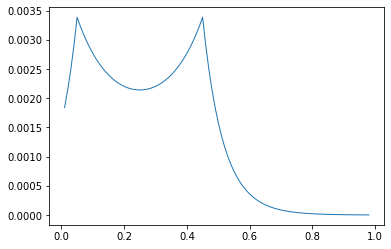

In [21]:
#fisher combining isn't even unimodal... i.e. it seems like it will be difficult to scale
plot_marts_eta(
    x = samples, 
    N = N, 
    lam_func = Bets.lam_fixed, 
    combine = "fisher", 
    theta_func = Weights.theta_fixed, 
    log = False)